## Učitavanje podataka

In [1]:
from covid_daily import data

In [2]:
import pandas as pd

df = pd.concat((data('serbia', 'graph-cases-daily'),
                data('serbia', 'graph-active-cases-total'),
                data('serbia', 'graph-deaths-daily')), axis=1)

df.columns = ['Novi', 'Aktivni', 'Umrli']

df = df.loc[:'2021-11-05']

In [3]:
df.fillna(0, inplace=True)

df = df.astype(int)

In [4]:
import numpy as np

datumi = np.arange(np.datetime64('2020-01-01'),
                   np.datetime64('2020-02-14'))

dodatak = pd.DataFrame(np.zeros((len(datumi), 3), int),
                       index=datumi, columns=df.columns)

df = pd.concat((dodatak, df))

## Prikaz podataka

In [5]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 85

In [6]:
def skaliraj(df):
    df = df.copy()
    
    for col in df.columns:
        df[col] = df[col] / df[col].max()
    
    return df

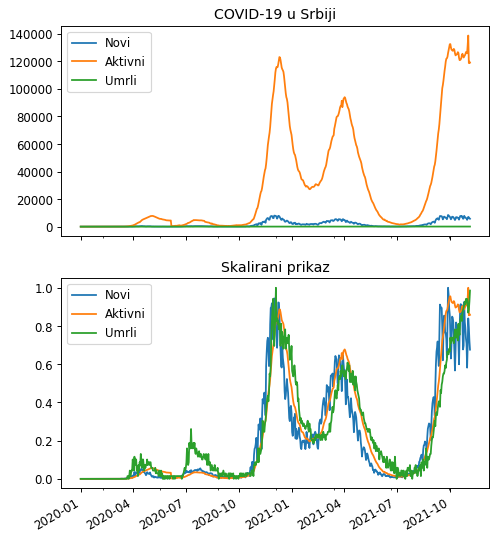

In [7]:
_, (ax1, ax2) = plt.subplots(2, 1, figsize=(6.5, 8), sharex=True)

df.plot(ax=ax1, title='COVID-19 u Srbiji')

skal = skaliraj(df)

_ = skal.plot(ax=ax2, title='Skalirani prikaz')

## Pomoćna klasa HMM

In [8]:
from matplotlib.ticker import NullLocator

class HMM:
    def __init__(self, model, **kwargs):
        self.model = model(random_state=0, **kwargs)
    
    def modeluj(self, podaci, metod):
        if hasattr(podaci, 'values'):
            podaci = podaci.values
        
        metod = getattr(self.model, metod)
        
        try:
            return metod(podaci)
        except:
            return metod(podaci.reshape(-1, 1))
    
    def fit(self, podaci):
        self.modeluj(podaci, 'fit')
        self.pred = self.predict(podaci)
        return self
    
    def refit(self, podaci):
        self.pred = self.predict(podaci)
        return self
    
    def predict(self, podaci):
        return self.modeluj(podaci, 'predict')
    
    def opis(self):
        print('Broj simbola:', self.model.n_features)
        print('Broj skrivenih stanja:', self.model.n_components)
        
        if hasattr(self.model, 'n_mix'):
            print('Broj mešavina:', self.model.n_mix)
        print()
        
        print('Polazne verovatnoće:')
        print(self.model.startprob_)
        print()
        
        print('Matrica prelaza:')
        print(self.model.transmat_)
        print()
        
        if hasattr(self.model, 'emissionprob_'):
            print('Matrica emisija:')
            print(self.model.emissionprob_)
        else:
            print('Srednje vrednosti:')
            print(self.model.means_)
            print()
            
            print('Kovarijanse:')
            print(self.model.covars_)
    
    def start(self, start):
        self.model.startprob_ = np.array(start)
    
    def trans(self, trans):
        self.model.transmat_ = np.array(trans)
    
    def emiss(self, emiss):
        self.model.emissionprob_ = np.array(emiss)
    
    def plot_prep(self, podaci, ax=None, **kwargs):
        if ax is None:
            ax = plt.gca()
        
        podaci.plot(ax=ax, **kwargs)
        
        klasa = self.model.__class__.__name__
        multi = klasa.startswith('M')
        kovar = '' if multi else f' ({self.model.covariance_type})'
        
        ax.set_title(f'{klasa}{kovar} ― {podaci.name.lower()}')
        
        ax.xaxis.set_minor_locator(NullLocator())
        
        if not hasattr(self, 'pred'):
            self.fit(podaci)
        
        return ax
    
    def plot(self, podaci, boje=None, leg=None, ax=None, ll=True, **kwargs):
        ax = self.plot_prep(podaci, ax, **kwargs)
        
        if leg is None:
            leg = boje if boje else range(self.model.n_components)
        
        if boje is None:
            np.random.seed(0)
            boje = [np.random.rand(3,) for _ in range(self.model.n_components)]
        
        i = 0
        for j in range(1, len(podaci)):
            if self.pred[j] != self.pred[i]:
                ax.axvspan(podaci.index[i], podaci.index[j],
                           alpha=0.4, color=boje[self.pred[i]])
                i = j
        
        ax.axvspan(podaci.index[i], podaci.index[j],
                   alpha=0.4, color=boje[self.pred[i]])
        
        legs = []
        
        for b, l in zip(boje, leg):
            legs.append(ax.axvspan(podaci.index[i], podaci.index[i],
                                   alpha=0.4, color=b, label=l))
        
        if leg and ll:
            ax.legend(legs, leg,
                      title='Ključ', loc=(1.1, 0.4 - 0.035*self.model.n_components),
                      fontsize=12, title_fontsize=12)
        elif leg and not ll:
            ax.legend(legs, leg, title='Ključ')
    
    def plot_activity(self, podaci, mere=[], ax=None):
        ax = self.plot_prep(podaci, ax)
        
        boje = ['y', 'r', 'g']
        
        if podaci[0] == podaci[1]:
            b = 0
        elif podaci[0] < podaci[1]:
            b = 1
        else:
            b = 2
        
        leg = ['plato', 'rast', 'pad']
        leg = [*leg[:b], *leg[b:]]
        
        i = 0
        for j in range(1, len(podaci)):
            if self.pred[j] != self.pred[i]:
                if self.pred[i] == 1:
                    ax.axvspan(podaci.index[i], podaci.index[j],
                               alpha=0.4, color=boje[0])
                    
                    b = 'r'
                else:
                    k = i + np.argmax(podaci[i:j])
                    
                    ax.axvspan(podaci.index[i], podaci.index[k],
                               alpha=0.4, color=boje[1])
                    
                    ax.axvspan(podaci.index[k], podaci.index[j],
                               alpha=0.4, color=boje[2])
                    
                    b = 'y'
                
                i = j
        
        ax.axvspan(podaci.index[i], podaci.index[j],
                   alpha=0.4, color=b)
        
        legs = []

        for b, l in zip(boje, leg):
            legs.append(ax.axvspan(podaci.index[i], podaci.index[i],
                                   alpha=0.4, color=b, label=l))
        
        for mera in mere:
            ax.axvline(mera, dashes=(3.1,), color='black')
        
        if mere:
            legs.append(*ax.plot([], [], dashes=(3.1,), color='black'))
        
        ax.legend(legs, [*leg, 'mere'],
                  title='Ključ', loc=(1.1, 0.4 - 0.035*self.model.n_components),
                  fontsize=12, title_fontsize=12)
    
    def plot_change(self, podaci, mere=[], ax=None):
        ax = self.plot_prep(podaci, ax)
        
        boje = ['r', 'orange', 'g', 'y']
        
        if podaci[0] == podaci[1]:
            b = 3
        elif podaci[0] < podaci[1]:
            b = 0
        else:
            b = 2
        
        leg = ['rast', 'pik', 'pad', 'plato']
        leg = [*leg[:b], *leg[b:]]
        
        i = 0
        for j in range(1, len(podaci)):
            if self.pred[j] != self.pred[i]:
                ax.axvspan(podaci.index[i], podaci.index[j],
                           alpha=0.4, color=boje[b])
                b = (b + 1) % len(boje)
                i = j
        
        ax.axvspan(podaci.index[i], podaci.index[j],
                   alpha=0.4, color=boje[b])
        
        legs = []

        for b, l in zip(boje, leg):
            legs.append(ax.axvspan(podaci.index[i], podaci.index[i],
                                   alpha=0.4, color=b, label=l))
        
        for mera in mere:
            ax.axvline(mera, dashes=(3.1,), color='black')
        
        if mere:
            legs.append(*ax.plot([], [], dashes=(3.1,), color='black'))
        
        ax.legend(legs, [*leg, 'mere'],
                  title='Ključ', loc=(1.1, 0.4 - 0.035*self.model.n_components),
                  fontsize=12, title_fontsize=12)
    
    def plot_pprep(self, args):
        broj = []
        
        j = 0
        for i in range(1, len(self.pred)):
            if self.pred[i-1] != self.pred[i]:
                broj.append(i-j)
                
                j = i
        
        broj.append(i-j+1)
        
        i = 0
        for arg in args:
            broj[i] = sum(broj[i:i+arg])
            
            del broj[i+1:i+arg]
            
            i += 1
        
        return i, broj
    
    def plot_parts(self, podaci, *args):
        i, broj = self.plot_pprep(args)
        
        pred = self.pred
        
        self.pred = [i for i in range(len(broj)) for j in range(broj[i])]
        
        n = self.model.n_components
        
        self.model.n_components = i
        
        self.plot(podaci, leg=[f'faza {j+1}' for j in range(i)])
        
        self.pred = pred
        
        self.model.n_components = n
    
    def plot_waves(self, podaci, *args):
        argss = []
        
        for arg in args:
            argss.extend([1, arg])
        
        i, broj = self.plot_pprep(argss)
        
        pred = self.pred
        
        self.pred = [i for i in range(len(broj)) for j in range(broj[i])]
        
        leg = []
        
        for j in range(i):
            leg.extend([f'pauza {j}', f'talas {j+1}'])
        
        leg[0] = 'zdravo'
        
        ax1, ax2 = grafici(2)
        
        n = self.model.n_components
        
        self.model.n_components = i
        
        self.plot(podaci, leg=leg, ax=ax2)
        
        self.pred = [j if not j else j%2 + 2 * (not j%2) for j in self.pred]
        
        self.model.n_components = 3
        
        self.plot(podaci, ['g', 'r', 'y'], ['zdravo', 'talas', 'pauza'], ax=ax1)
        
        self.pred = pred
        
        self.model.n_components = n

## Naivni diskretni HMM

In [9]:
from hmmlearn.hmm import MultinomialHMM

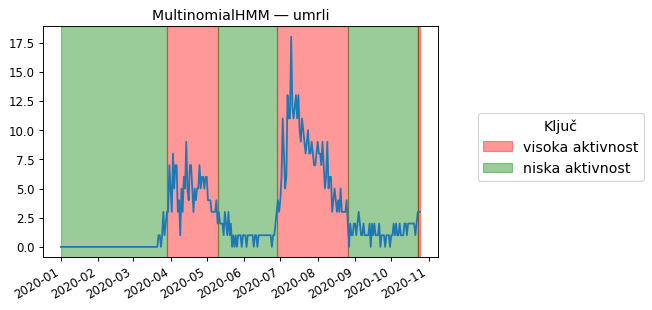

In [10]:
umrli = df['Umrli'].loc[:'2020-10-25']

model = HMM(MultinomialHMM, n_components=2).fit(umrli)

model.plot(umrli, ['r', 'g'], ['visoka aktivnost', 'niska aktivnost'])

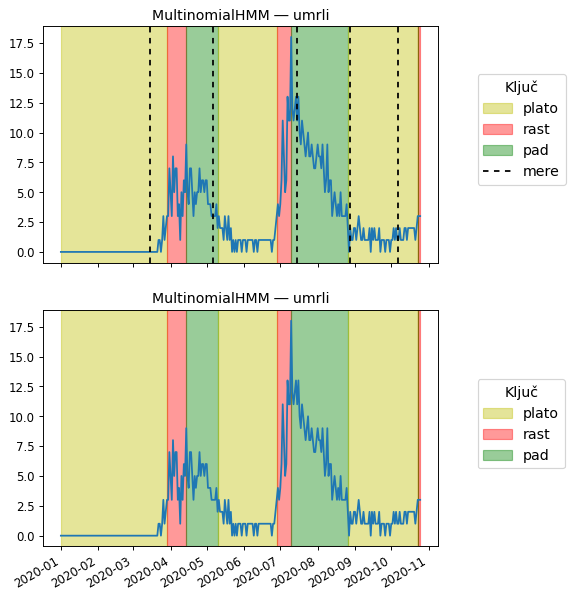

In [11]:
grafici = lambda n, k=1, sx='col', sy='row': \
                 plt.subplots(n, k, figsize=(6*k, 4.5*n),
                              sharex=sx, sharey=sy)[1]

mere = ['2020-03-15', # proglašeno vanredno stanje
        '2020-05-06', # ukinuto vanredno stanje
        '2020-07-15', # pojačane mere: maske itd.
        '2020-08-28', # radno vreme posle ponoći
        '2020-10-07'] # skraćeno radno vreme

ax1, ax2 = grafici(2)

model.plot_activity(umrli, ax=ax2)
model.plot_activity(umrli, mere, ax1)

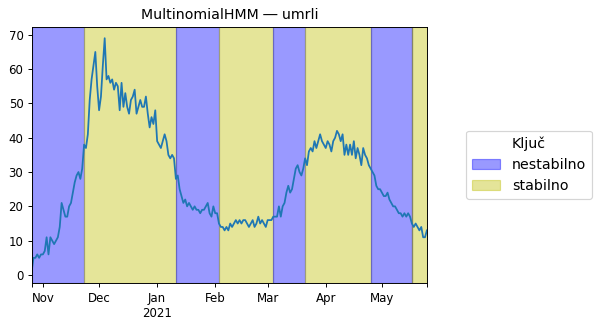

In [12]:
umrli = df['Umrli'].loc['2020-10-26':'2021-05-25']

model = HMM(MultinomialHMM, n_components=2).fit(umrli)

model.plot(umrli, ['b', 'y'], ['nestabilno', 'stabilno'])

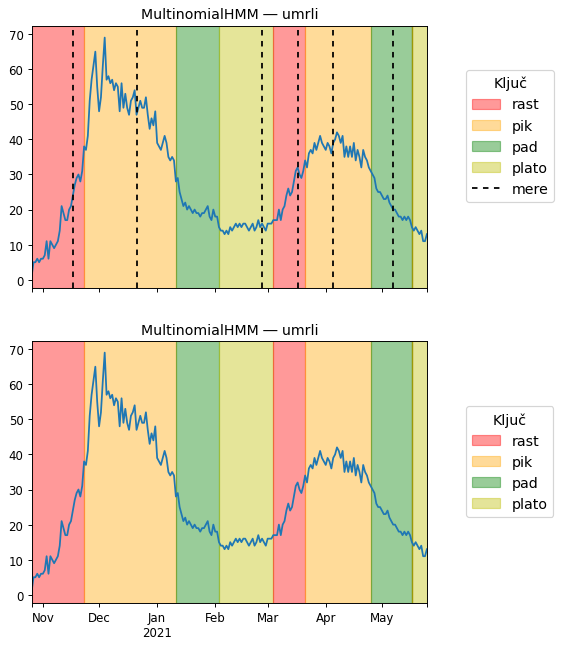

In [13]:
mere = ['2020-11-17', # pojačane zabrane rada
        '2020-12-21', # popuštene zabrane rada
        '2021-02-26', # skraćeno radno vreme
        '2021-03-17', # zatvoreni ugostitelji
        '2021-04-05', # otvoreni ugostitelji
        '2021-05-07'] # skoro sve otvoreno

ax1, ax2 = grafici(2)

model.plot_change(umrli, ax=ax2)
model.plot_change(umrli, mere, ax1)

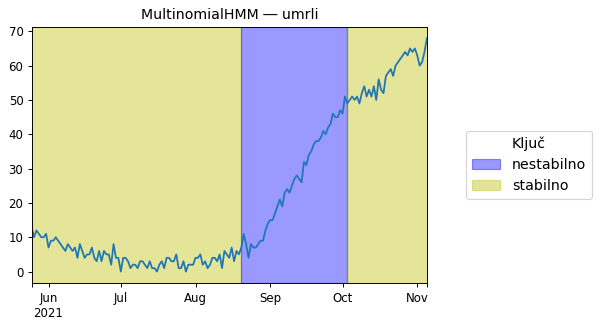

In [14]:
umrli = df['Umrli'].loc['2021-05-25':]

model = HMM(MultinomialHMM, n_components=2).fit(df['Umrli'])

model.plot(umrli, ['b', 'y'], ['nestabilno', 'stabilno'])

## Napredni diskretni HMM

In [15]:
dff = df.rolling(7).mean().fillna(0)

for col in dff.columns:
    dff[col] = np.int64(np.ediff1d(dff[col], to_begin=0) > 0)

In [16]:
model = HMM(MultinomialHMM, n_components=2).fit(dff['Aktivni'])

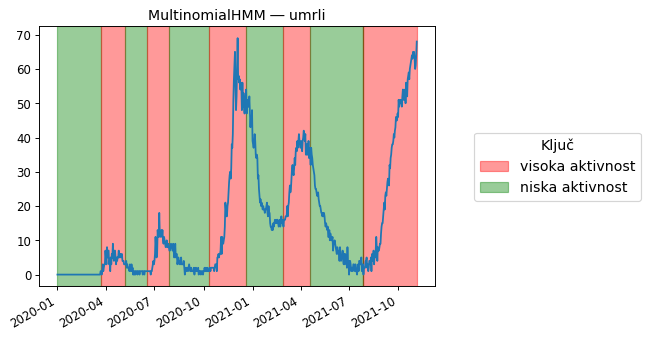

In [17]:
dff = df.rolling(7).mean().fillna(0) \
        .rolling(10).mean().fillna(0) \
        .rolling(14).mean().fillna(0)

for col in dff.columns:
    dff[col] = np.int64(np.ediff1d(dff[col], to_begin=0) > 0)

ax = grafici(1)

model.refit(dff['Umrli']) \
     .plot(df['Umrli'], ['r', 'g'],
     ['visoka aktivnost', 'niska aktivnost'], ax)

## Nivelisanje promene

In [18]:
dff = df.rolling(7).mean().fillna(0) \
        .rolling(7).std().fillna(0)
dff = skaliraj(dff)

dff1 = dff.loc[:'2020-10-31']
dff2 = dff.loc['2020-11-01':]

In [19]:
thresh1, thresh2 = 0.015, 0.16

In [20]:
dff = pd.concat(((dff1 < thresh1).astype(int),
                 (dff2 < thresh2).astype(int)))

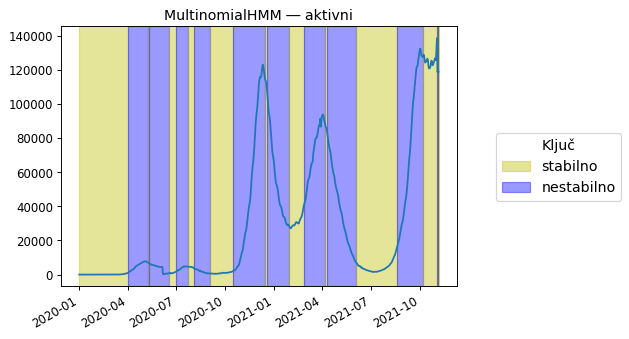

In [21]:
ax = grafici(1)

HMM(MultinomialHMM, n_components=2).fit(dff['Aktivni']) \
.plot(df['Aktivni'], ['y', 'b'], ['stabilno', 'nestabilno'], ax)

In [22]:
model = HMM(MultinomialHMM, n_components=2).fit(dff['Aktivni'])

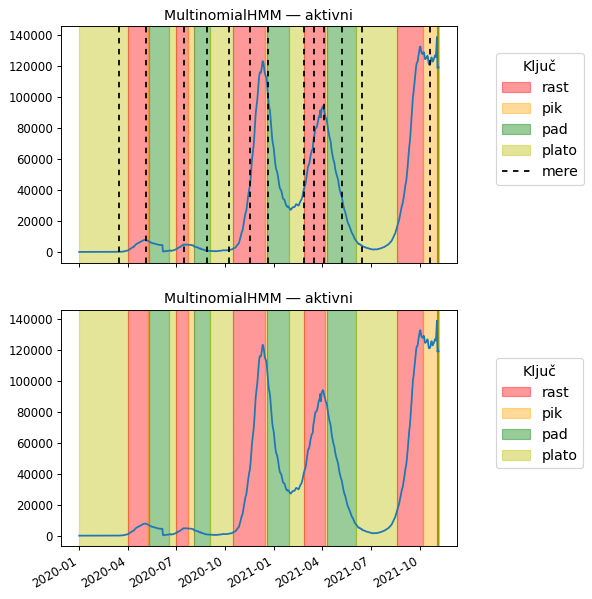

In [23]:
mere = ['2020-03-15', # proglašeno vanredno stanje
        '2020-05-06', # ukinuto vanredno stanje
        '2020-07-15', # pojačane mere: maske itd.
        '2020-08-28', # radno vreme posle ponoći
        '2020-10-07', # skraćeno radno vreme
        '2020-11-17', # pojačane zabrane rada
        '2020-12-21', # popuštene zabrane rada
        '2021-02-26', # skraćeno radno vreme
        '2021-03-17', # zatvoreni ugostitelji
        '2021-04-05', # otvoreni ugostitelji
        '2021-05-07', # skoro sve skroz otvoreno
        '2021-06-14', # maksimalno radno vreme
        '2021-10-20'] # uvedene kovid propusnice

ax1, ax2 = grafici(2)

model.plot_change(df['Aktivni'], ax=ax2)
model.plot_change(df['Aktivni'], mere, ax1)

## Neprekidni (Gausov) HMM

In [24]:
from hmmlearn.hmm import GaussianHMM

In [25]:
dfm = df.rolling(7).mean().fillna(0)
dfs = dfm.rolling(7).std().fillna(0)

dff = pd.concat((df, dfm, dfs), axis=1)

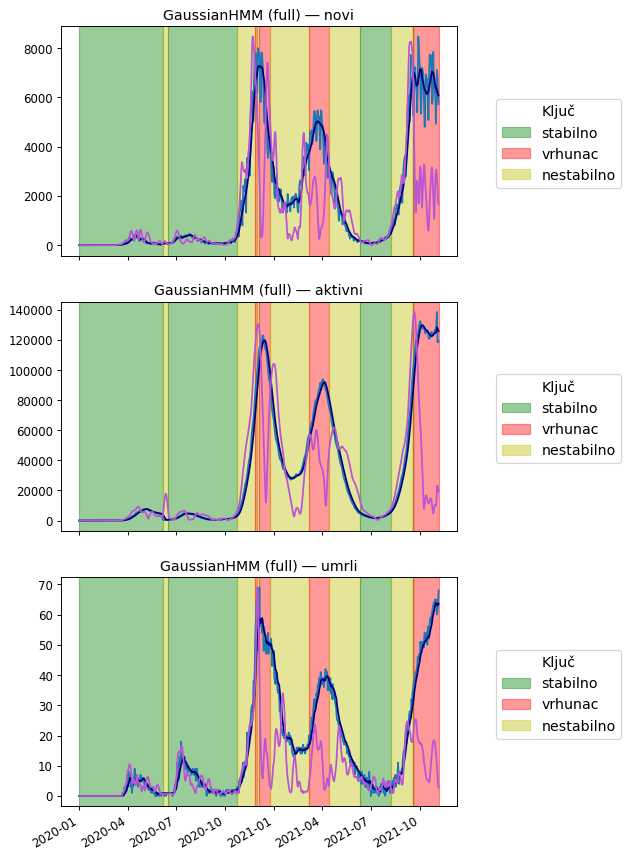

In [26]:
model = HMM(GaussianHMM, n_components=3,
            covariance_type='full').fit(dff)

for i, ax in enumerate(grafici(3, 1)):
    sirovi = dff.iloc[:, i]
    model.plot(sirovi, 3*['w'], ax=ax)
    
    proseci = dff.iloc[:, i+3]
    model.plot(proseci, 3*['w'], ax=ax, color='navy')
    
    odstupanja = dff.iloc[:, i+6]
    odstupanja = odstupanja / odstupanja.max()
    odstupanja = odstupanja * sirovi.max()
    model.plot(odstupanja, ['g', 'r', 'y'],
               ['stabilno', 'vrhunac', 'nestabilno'],
               ax, color='mediumorchid')

## Multivarijantni modeli

In [27]:
drzave = ['croatia', 'bosnia-and-herzegovina']
brojevi = ['graph-cases-daily', 'graph-active-cases-total', 'graph-deaths-daily']

dff = df

for drzava in drzave:
    for broj in brojevi:
        dff = pd.concat((dff, data(drzava, broj)), axis=1)

dff = dff.loc[:'2021-11-05'].fillna(0).astype(int)

dff.columns = [f'{d}{col}' for d in ('s', 'c', 'b') for col in df.columns]

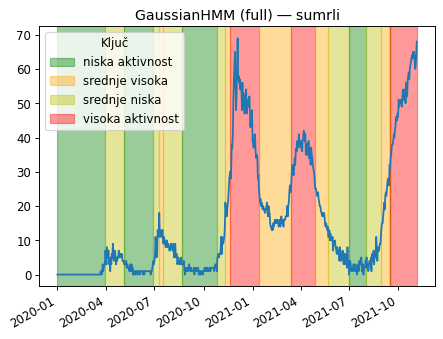

In [28]:
ax = grafici(1)

podaci = dff.iloc[:, 2]

bojozn = {
    'g': 'niska aktivnost',
    'y': 'srednje niska',
    'orange': 'srednje visoka',
    'r': 'visoka aktivnost'
}

boje = ['g', 'orange', 'y', 'r']
oznake = [bojozn[b] for b in boje]

HMM(GaussianHMM, n_components=4, covariance_type='full') \
    .fit(podaci).plot(podaci, boje, oznake, ax, i%2)

In [29]:
dff.to_csv('COVID-19 podaci.csv')

## Veći broj stanja

In [30]:
dff.columns = 3 * ['Novi', 'Aktivni', 'Umrli']

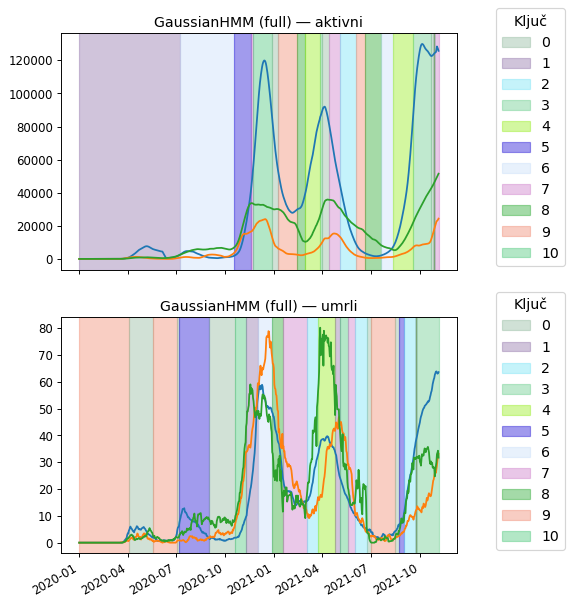

In [31]:
pods, mods = [], []

for i, ax in enumerate(grafici(2)):
    podaci = dff.iloc[:, [i + 1 + 3*j for j in range(3)]]
    podaci = podaci.rolling(7).mean().fillna(0)
    
    podaci.name = dff.columns[i+1]
    pods.append(podaci)
    
    model = HMM(GaussianHMM, n_components=11, covariance_type='full')
    mods.append(model)
    
    model.fit(podaci).plot(podaci, ax=ax)

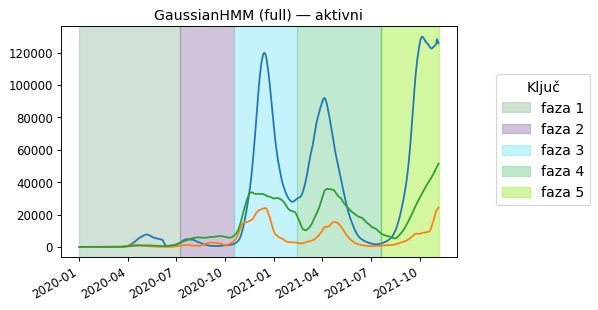

In [32]:
mods[0].plot_parts(pods[0], 1, 1, 6, 8, 5)

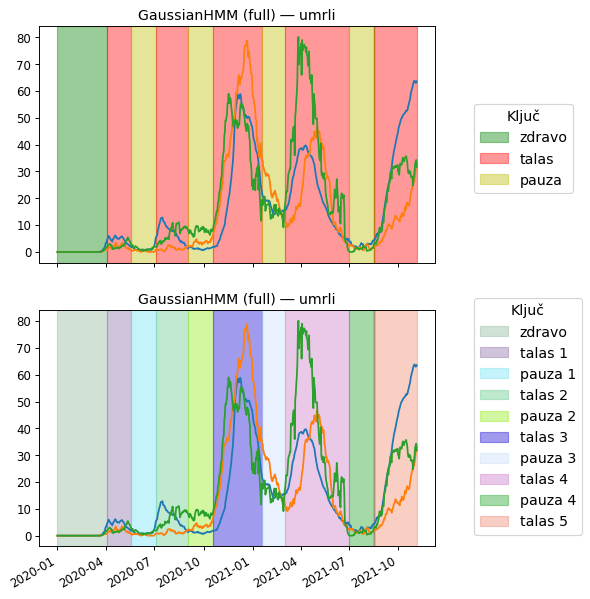

In [33]:
mods[1].plot_waves(pods[1], 1, 2, 4, 7, 6)